# Mendelian Randomization using the generated simulated data

## Simulate dataset for further MR analysis

In [226]:
import os
import numpy as np
import itertools
import pandas as pd
from scipy.sparse import load_npz
from itertools import combinations
import pdb

class GeneticSimulation:
    
    def __init__(self, dataset_size=10027, num_exposures=5, num_outcomes=3, seed=11):
        self.dataset_size = dataset_size
        self.num_exposures = num_exposures
        self.num_outcomes = num_outcomes
        self.num_causal_variants = int(dataset_size * 0.05)
        self.num_variables = num_exposures + num_outcomes
        self.rng = np.random.default_rng(seed=seed)
        self.LD_sparse = None
        self.h2 = 0.1
        self.pleiotropy_prop = 0.1
        self.prop_directionnal = 0.7
        # Generate correlated_effect matrix once during initialization
        #self.correlated_effect = self.generate_correlated_effect_matrix(
        #    num_rows=self.num_exposures, num_columns=self.num_outcomes,
        #    null_prob=0.5, low=0.1, high=0.3, seed=self.rng.integers(0, 1000)
        #)
        # Save the correlated_effect matrix as a NumPy file
        #np.savetxt('correlated_effect_matrix.csv', self.correlated_effect, delimiter='\t')

        

    def load_LD_sparse(self, file_path):
        self.LD_sparse = load_npz(file_path)
        
    def set_causal_variants(self, pleiotropy_prop):
        """
        Set the causal variants for exposures in the simulated dataset.
        Parameters:
        - pleiotropy_prop (float): Proportion of pleiotropic variants.
        Returns:
        - np.ndarray: Array containing lists of causal variants for each exposure.
        """
        
        pleio = []
        
        if pleiotropy_prop == 0:
            all_causal_variants = []
            # Choose significant variants for all exposures
            all_variants = np.arange(self.dataset_size)
            causal_list = self.rng.choice(all_variants, size=self.num_causal_variants, replace=False)
            # Divide the list into exposures
            all_causal_variants = np.array_split(causal_list, self.num_exposures)
    
        if pleiotropy_prop > 0:
            all_causal_variants = [[] for _ in range(self.num_exposures)]
            # Generate all pairs of exposures
            exposure_pairs = list(itertools.combinations(range(self.num_exposures), 2))
            # Calculate the number of pleiotropic variants per pair
            # pdb.set_trace()
            causal_variants_per_exposure = int(self.num_causal_variants / self.num_exposures)
            pleiotropic_variant_count_per_pair = int((causal_variants_per_exposure * pleiotropy_prop) / (self.num_exposures - 1))
            

            # Assign pleiotropic variants to each pair
            # pdb.set_trace()
            for pair in exposure_pairs:
                pleiotropic_variants_for_pair = self.rng.choice(self.dataset_size, size=pleiotropic_variant_count_per_pair, replace=False)
                pleio.append(pleiotropic_variants_for_pair)
                # Add these pleiotropic variants to the exposures in the pair
                for exposure in pair:
                    all_causal_variants[exposure] = np.unique(np.concatenate((all_causal_variants[exposure], pleiotropic_variants_for_pair)))
                    
            # Assign unique variants to each exposure
            for exposure_index in range(self.num_exposures):
                unique_variant_count = causal_variants_per_exposure - len(all_causal_variants[exposure_index])

                unique_variants = self.rng.choice(self.dataset_size, size=unique_variant_count, replace=False)

                all_causal_variants[exposure_index] = np.unique(np.concatenate((all_causal_variants[exposure_index], unique_variants)))            

        return all_causal_variants,pleio

    def generate_correlated_effect_matrix(self, num_rows=100, num_columns=3, null_prob=0.5, low=0.1, high=0.3, seed=None):
        # NOTE: THIS FUNCTION WILL NOT BE USED IN THIS TUTORIAL, correlated_effect will be predifined in the testing code 
        """
        Generate a correlated_effect matrix with random values and introduce variability.

        Parameters:
        - num_rows (int): Number of rows in the matrix.
        - num_columns (int): Number of columns in the matrix.
        - null_prob (float): Probability of setting an effect to zero.
        - low (float): Lower bound for random values.
        - high (float): Upper bound for random values.
        - seed (int): Seed for random number generation.

        Returns:
        - np.ndarray: Correlated_effect matrix with random values and variability.
        """
        num_rows = self.num_exposures if num_rows is None else num_rows
        num_columns = self.num_outcomes if num_columns is None else num_columns

        rng = np.random.default_rng(seed=seed)
        correlated_effect = rng.uniform(low=low, high=high, size=(num_rows, num_columns))

        # Introduce variability by randomly setting some effects to zero
        null_mask = rng.random(size=(num_rows, num_columns)) < null_prob
        correlated_effect[null_mask] = 0.0

        return correlated_effect

    
    def simulate_base_dataset(self, h2=0.5, pleiotropy_prop=0.1,seed = None):
        all_causal_variants,pleio = self.set_causal_variants(pleiotropy_prop)

        # Calculate the overall phenotypic variance using heritability (h2)
        sigma_causal = (1 + (self.dataset_size * h2) / self.num_causal_variants)
        # Simulate genetic components
        base_dataset = self.rng.normal(size=(self.dataset_size, self.num_variables))
        base_dataset = pd.DataFrame(base_dataset)
        paires = list(combinations(range(self.num_exposures), 2))
        i = 0
        keep_pleio = []
        if len(pleio) > 0:
            # concatenation 
            all_pleio = np.concatenate(pleio)
            # we keep only x percent of the list
            keep_pleio = np.random.choice(all_pleio,int(self.prop_directionnal*len(all_pleio)), replace=False)
            rm_pleio = list(set(all_pleio) - set(keep_pleio))

            for pleio_exposure in pleio:
                significant_variants = list(set(pleio_exposure) - set(rm_pleio))
                sigmas_exposure = self.rng.normal(0, sigma_causal, (len(significant_variants),2))
                colonnes = [self.num_outcomes+paires[i][0],self.num_outcomes+paires[i][1]]
                base_dataset.iloc[significant_variants,colonnes] = abs(sigmas_exposure)

        # Apply causal variance to the subset of rows representing significant variants
        for exposure_index, significant_variants in enumerate(all_causal_variants):
            significant_variants = list(set(significant_variants)-set(keep_pleio))
            significant_variants = np.array(significant_variants, dtype = int)
            sigmas_exposure = self.rng.normal(0, sigma_causal, len(significant_variants))
            base_dataset.iloc[significant_variants, self.num_outcomes + exposure_index] = sigmas_exposure

       
        # Create column names for the DataFrame
        col_names = [f"Y_{i + 1}" for i in range(self.num_outcomes)] + [f"X_{i + 1}" for i in range(self.num_exposures)]
        # Create the final DataFrame
        base_dataset.columns = col_names
        # base_dataset_df = pd.DataFrame(base_dataset, columns=col_names)

        return base_dataset,all_causal_variants,pleio


    def propagate_LD_sparse(self, ld_sparse_matrix, effect_sizes):
        """
        Propagate LD effects through the simulated dataset.

        - ld_sparse_matrix (scipy.sparse.csr_matrix): Sparse matrix representing LD information.
        - effect_sizes (np.ndarray): Array of effect sizes.

        Returns:
        - np.ndarray: Array of propagated effect sizes.
        """
        propagated_effect_sizes = effect_sizes.copy()
        for i in range(ld_sparse_matrix.shape[0]):
            if np.any(ld_sparse_matrix.getrow(i).data):
                ld_row = ld_sparse_matrix.getrow(i).toarray().flatten()
                ld_adjustment = np.dot(ld_row, effect_sizes)
                propagated_effect_sizes += ld_adjustment

        return propagated_effect_sizes

    def simulate_outcomes(self, base_dataset_LD, correlated_effect, causal_variants,pleio):
        """
        Simulate outcomes based on the correlated_effect matrix.

        Parameters:
        - base_dataset_LD (pd.DataFrame): Simulated dataset with genetic components and LD propagation.
        - correlated_effect (np.ndarray): Array representing the correlation between outcomes and exposures.

        Returns:
        - pd.DataFrame: DataFrame containing simulated outcomes.
        """
        paires = list(combinations(range(self.num_exposures), 2))
        i = 0
        if len(pleio) > 0:
            for pleio_exposure in pleio:
                X = base_dataset_LD.iloc[pleio_exposure,[self.num_outcomes+paires[i][0],self.num_outcomes+paires[i][1]]]
                X = pd.DataFrame(X)
                matrix = np.random.uniform(low=0.1, high=0.5, size=(correlated_effect.shape[1], correlated_effect.shape[1]))
                noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
                print(sum(noise))
                outcomes = np.dot(X, correlated_effect[(paires[i][0],paires[i][1]),:])+noise
                base_dataset_LD.iloc[pleio_exposure,:self.num_outcomes] = outcomes
                i += 1
        for index,pleio_nopleio in enumerate(causal_variants):
            if len(pleio) > 0:
                nonpleio_exposures = list(set(pleio_nopleio) - set(np.concatenate(pleio))) # ordre ?
            else:
                nonpleio_exposures = list(set(pleio_nopleio))
            nonpleio_exposures = [int(x) for x in nonpleio_exposures]
            X = base_dataset_LD.iloc[nonpleio_exposures,self.num_outcomes+index]
            X = pd.DataFrame(X)
            matrix = np.random.uniform(low=0.1, high=0.5, size=(correlated_effect.shape[1], correlated_effect.shape[1]))
            noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
            print(sum(noise))
            outcomes = np.dot(X, correlated_effect[index,:].reshape(1, -1))+noise
            base_dataset_LD.iloc[nonpleio_exposures,:self.num_outcomes] = outcomes
            
        return base_dataset_LD
        
        
    def simulate_dataset(self, correlated_effect, pleiotropy_prop=0.1, h2=0.1, seed=None):
        """
        Simulate a complete final dataset including base genetic components, LD propagation, and outcomes.

        Parameters:
        - correlated_effect (np.ndarray): Array representing the correlation between outcomes and exposures.
        - pleiotropy_prop (float): Proportion of pleiotropic variants.
        - h2 (float): Heritability.
        - seed (int): Seed for random number generation.

        Returns:
        - pd.DataFrame: Simulated dataset with outcomes and exposures.
        - np.ndarray: Array containing lists of causal variants for each exposure.
        """
        if self.LD_sparse is None:
            raise ValueError("LD matrix not loaded. Use 'load_LD_sparse' method to load the LD matrix.")

        # Simulate the base dataset with genetic components and LD propagation
        base_dataset, all_causal_variants,pleio = self.simulate_base_dataset(h2=h2, pleiotropy_prop=pleiotropy_prop, seed=seed)
        # Simulate outcomes based on the correlated dataset
        base_dataset = self.simulate_outcomes(base_dataset, correlated_effect,all_causal_variants,pleio)

        # Update outcomes in the base dataset
        # base_dataset.iloc[np.concatenate(all_causal_variants).astype(int), :self.num_outcomes] = outcomes_df.values

        # Apply LD propagation to the entire dataset
        LD_sparse = self.LD_sparse.tocsr()
        base_dataset_LD = self.propagate_LD_sparse(LD_sparse, base_dataset)

        # Center exposures and outcomes by subtracting the mean of all variables
        mean_all_variables = base_dataset_LD.mean()
        base_dataset_LD -= mean_all_variables # une sorte de nomalisation
        
        # Rename columns
        col_names = [f"Y_{i + 1}" for i in range(self.num_outcomes)] + [f"X_{i + 1}" for i in range(self.num_exposures)]
        base_dataset_LD.columns = col_names

        # Return the base dataset and indices of significant variants
        return base_dataset_LD, all_causal_variants,pleio

    def compute_std_deviation(self, simulated_dataset):
        """
        Compute the standard deviation of the final simulated dataset.

        Parameters:
        - simulated_dataset (pd.DataFrame): The simulated dataset.

        Returns:
        - std_deviation (float): The standard deviation of the dataset.
        """

        # Compute the standard deviation of the entire dataset
        std_deviation = simulated_dataset.std()

        return std_deviation

    
    def verify_number_of_IVs(self, simulated_dataset):
        """
        Verify the number of independent variables (IVs) based on the specified criterion.

        Parameters:
        - simulated_dataset (pd.DataFrame): The simulated dataset.

        Returns:
        - num_IVs (int): The number of IVs that meet the specified criterion.
        - num_IVs_pleiotropic (int): The number of IVs with normalized betas > 5.45131 for at least two exposures.
        - IVs_indices (np.ndarray): The indices of identified IVs (row indices).
        """

        # Extract the beta values for the exposures only
        exposure_betas = simulated_dataset.iloc[:, self.num_outcomes:self.num_outcomes + self.num_exposures].values

        # Calculate the variance of the beta values
        variance_betas = np.var(exposure_betas, axis=0)
        # Calculate the normalized beta values using the variance
        normalized_betas = np.abs(exposure_betas / np.sqrt(variance_betas))

        # Identify IVs based on the threshold
        dict_IVs = {}
        for exposure in range(self.num_exposures): # self.num_exposures
            IVs_indices = np.where(np.abs(normalized_betas[:,exposure]) > 5.45131)[0]
            dict_IVs[f"X_{exposure+1}"] = IVs_indices

        # Count the number of identified IVs
        num_IVs = sum(len(valeurs) for valeurs in dict_IVs.values())
        # pdb.set_trace()
        # Identify pleiotropic IVs (normalized betas > 5.45131 for at least two exposures)
        pleiotropic_IVs_indices = np.where(np.sum(normalized_betas > 5.45131, axis=1) >= 2)[0]
        num_pleiotropic_IVs = len(pleiotropic_IVs_indices)

        return num_IVs, num_pleiotropic_IVs, dict_IVs, pleiotropic_IVs_indices

    def run_scenario(self, pleiotropy_prop, h2, num_datasets, parent_folder="PleioLin"):
        """
        Run a scenario of the genetic simulation for multiple datasets.

        Parameters:
        - pleiotropy_prop (float): Proportion of pleiotropic variants.
        - h2 (float): Heritability.
        - num_datasets (int): Number of datasets to simulate.
        - parent_folder (str): Parent folder to save results.

        Returns:
        - list: List of dictionaries containing information for each simulated dataset.
        """
        model_results = []
        
        # Create parent folder if it doesn't exist
        if not os.path.exists(parent_folder):
            os.makedirs(parent_folder)

        for dataset_num in range(1, num_datasets + 1):
            # Change the seed for each iteration
            seed_for_iteration = self.rng.integers(0, 2**31 - 1)
            
            # Run the simulation for a single dataset
            base_dataset, all_causal_variants,pleio = self.simulate_dataset(
                correlated_effect=correlated_effect,
                pleiotropy_prop=pleiotropy_prop,
                h2=h2,
                seed=seed_for_iteration
            )
            
            # Save the base dataset to a CSV file
            scenario_folder = f'Scenario{int(pleiotropy_prop * 100)}_h2{h2}'
            scenario_path = os.path.join(parent_folder, scenario_folder)
            if not os.path.exists(scenario_path):
                os.makedirs(scenario_path)
            base_dataset.to_csv(os.path.join(scenario_path, f'dataset_{dataset_num}.csv'), index=False)

            # Verify the number of IVs and get relevant information
            num_IVs, num_pleiotropic_IVs, IVs_indices, pleiotropic_IVs_indices = self.verify_number_of_IVs(base_dataset)

            # Compute the standard deviation of the final simulated dataset
            std_deviation = self.compute_std_deviation(base_dataset)

            # Save causal variants to CSV files
            # causal_variants_df = pd.DataFrame({'causal_variants': all_causal_variants})
            # causal_variants_df.to_csv(os.path.join(scenario_path, f'causal_variants_{dataset_num}.csv'), index=False)

            # Save IVs_indices to CSV for each dataset
            IVs_indices_df = pd.DataFrame({'IVs_indices': IVs_indices})
            IVs_indices_df.to_csv(os.path.join(scenario_path, f'IVs_indices_{dataset_num}.csv'), index=False)

            # Save pleiotropic_IVs_indices to CSV for each dataset
            pleiotropic_IVs_indices_df = pd.DataFrame({'pleiotropic_IVs_indices': pleiotropic_IVs_indices})
            pleiotropic_IVs_indices_df.to_csv(os.path.join(scenario_path, f'pleiotropic_IVs_indices_{dataset_num}.csv'), index=False)

            # Save std_deviation to CSV for each dataset
            pd.DataFrame({'std_deviation': [std_deviation]}).to_csv(os.path.join(scenario_path, f'std_deviation_{dataset_num}.csv'), index=False)

            # Save params.txt
            with open(os.path.join(scenario_path, 'params.txt'), 'w') as params_file:
                params_file.write(f"Pleiotropic Variants (%): {pleiotropy_prop * 100}\n")
                params_file.write(f"Heritability: {h2}\n")
                params_file.write(f"Seed for Iteration: {seed_for_iteration}\n")

            # Store the relevant information in a dictionary
            result = {
                "Pleiotropic Variants (%)": pleiotropy_prop * 100,
                "Heritability": h2,
                "Base Dataset": base_dataset,
                "Causal Variants": np.concatenate(all_causal_variants),
                "Divided CV": all_causal_variants,
                "IV Indices": IVs_indices,
                "Num IVs":num_IVs,
                "pleio":pleio,
                "num pleiotropic IVs": num_pleiotropic_IVs,
                "pleiotropic IVs indices": pleiotropic_IVs_indices,
                "Standard Deviation": std_deviation,
                "Seed for Iteration": seed_for_iteration
            }
            model_results.append(result)

        return model_results

In [227]:
genetic_simulator = GeneticSimulation()
genetic_simulator.load_LD_sparse("ld_matrix.npz")
correlated_effect = np.array([
                [0.15, 0.1, 0.2],
                [0.2, 0.15, 0.1],
                [0.15, 0.0, 0.0],
                [0.0, 0.25, 0.0],
                [0.0, 0.0, 0.25]
            ])
scenarios = [
    {"pleiotropy_prop": 0, "h2": 0.1, "num_datasets": 10},
    {"pleiotropy_prop": 0.5, "h2": 0.1, "num_datasets": 10},
    {"pleiotropy_prop": 0, "h2": 0.5, "num_datasets": 10},
    {"pleiotropy_prop": 0.5, "h2": 0.5, "num_datasets": 10}]
all_results = []
for scenario in scenarios:
    model_results = genetic_simulator.run_scenario(
        pleiotropy_prop=scenario["pleiotropy_prop"],
        h2=scenario["h2"],
        num_datasets=scenario["num_datasets"],
        parent_folder="PleioLin"
    )
    all_results.extend(model_results)

/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[-4.92430645 -3.86349476 -5.25148161]
[8.36082207 9.56376676 3.02006368]
[ 3.38851511 -0.58952337  0.4262756 ]
[11.3805357   0.9949164   1.24628798]
[-2.8683779   0.08609133  1.62724221]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[ 0.76438792 -1.00386949  2.02845363]
[ 1.20328    3.7976393 12.2398122]
[10.42919648 17.58759471  7.80833062]
[-2.86299838 -4.03812852 -4.77084549]
[ 0.85765377 -7.70709567 -5.67452229]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[ -6.26580877  -5.50229963 -12.00565041]
[-0.37420249 -0.53897254 -3.07797285]
[7.83329154 5.86530378 3.0971004 ]
[4.15312382 0.12577631 1.00908937]
[-1.53913594 -3.15280639  0.32805631]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[ 2.43251534 -2.85331932 -6.17041788]
[ -3.69129286  -7.37083521 -12.82602728]
[ 3.52321417 -2.56234393 -4.40199041]
[-1.54904376 -1.78539579 -4.18151069]
[-3.21438293 -3.56501443  2.59620831]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[-9.07481083 -3.13658397 -5.05529975]
[7.18376007 4.97908076 6.31363483]
[-2.42101003 -6.16587972 -8.99960457]
[ 9.12349509  9.12993725 11.43067165]
[-1.73991293 -6.25065279 -2.99153592]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[14.81060775  5.67217873  6.47961696]
[-6.33049207  0.90261404 -0.4915069 ]
[ -4.32805856 -11.08044427  -4.17415651]
[ -4.49207011 -12.58032162  -3.79621336]
[-9.01019526 -7.43292193 -2.04583507]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[-6.44960541 -6.66873156 -8.70292292]
[-1.59977326  1.29033825  4.15550247]
[-10.40299226  -2.80317746  -2.29996969]
[ 1.0862912  -6.4399832   3.43930556]
[-4.29678467  2.32646346 -2.01772489]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[-11.79277056  -3.4775556   -4.70785525]
[6.69911293 8.8826732  3.8685902 ]
[0.63304243 1.9548775  7.03569377]
[-3.0794702   2.44373643  0.18587311]
[-5.64449374 -3.10847186 -7.48390508]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[ -8.59863056  -1.69283802 -14.48159693]
[-15.03459628  -6.41118139  -2.46608747]
[13.65352638  1.45221502  1.39542092]
[ -5.33384352 -11.56793539  -5.70909132]
[-3.46805477 -2.97754789  1.73657399]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[9.40397285 7.45617021 4.76247604]
[ 1.00585212  2.57863177 -7.52255874]
[-0.28934682  2.8362456   6.74035012]
[ 1.41759537  0.67188615 12.50519251]
[-2.14124005  4.29548237  0.5290065 ]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:190: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[ 1.59294666 -0.73214171 -0.441795  ]
[0.59581352 1.80228884 0.86011074]
[-0.25030061  0.96632984 -0.83121342]
[-4.27235642 -1.16637695  0.74875676]
[-0.263218   -1.64307125 -0.24386249]
[-2.41847404 -2.01632882 -2.20575354]
[2.1921532  2.83632768 1.91707449]
[-3.61492079 -3.04834935 -3.87992813]
[-2.09471274 -4.10243923 -0.56069446]
[ 1.9023884  -0.67839281  4.1177745 ]
[-1.8297173   1.39479938 -1.77462698]
[-3.17521291 -2.64646347 -4.10768146]
[ 0.03929767 -3.5904916  -0.57280771]
[-5.18737294 -4.37605057 -6.41253251]
[4.40727222 9.19429874 8.336328  ]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:190: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[1.45501292 3.08855492 2.33295311]
[-0.28484986  1.35629824  1.72118035]
[ 1.01231639 -3.37493583 -0.90655367]
[-0.90823837 -2.69532764 -1.30665297]
[2.21941135 3.48736283 2.33945609]
[-1.24401513  1.71481778  0.77910411]
[-1.97726134 -0.19618871 -0.77108286]
[-1.71749919 -2.09493255 -1.54150058]
[-0.00446318  2.908591    0.76147834]
[-0.23575572 -0.59769908 -0.97193707]
[ 4.93772345 -0.09741797  1.34592079]
[-4.07218324 -1.60363541 -2.46805354]
[ -7.0318822  -10.17658115  -4.87331518]
[1.83405629 7.45904256 2.30768843]
[1.79924912 2.85351343 5.74952826]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:190: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[-4.07787133 -4.3148287  -5.14815694]
[-1.42222433 -0.73512662  0.55892431]
[ 1.1192598  -3.64740103 -2.34786026]
[-2.70583478 -1.40350826 -0.37765533]
[-3.73032255 -5.90841606 -2.7913836 ]
[-2.21113374 -2.85957658 -2.67152033]
[ 1.69228961  0.59003525 -2.38392155]
[-0.41825667 -0.54524503 -0.04094017]
[-0.49317759 -0.91222696 -1.03103494]
[-0.82686789 -0.31245236 -2.62887144]
[-5.17494881 -7.03875325 -5.20640795]
[-6.99522684 -4.43471646 -2.11098254]
[-3.16881612 -4.70218748  1.74097498]
[-4.21130358 -3.6630647  -7.25896037]
[-3.04349613 -5.9703649  -3.60064393]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:190: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[-0.5176057   1.3118597  -0.39270772]
[-3.76805799 -1.65139775 -1.56335054]
[-1.64863964 -1.84531207 -4.94104429]
[0.75820329 1.06607503 2.50167131]
[5.25633714 4.79451173 4.45429136]
[1.37999226 2.1797161  0.16399764]
[ 0.82362974  1.31973941 -0.63545848]
[0.64503936 1.21924483 4.04892217]
[-1.05078867 -0.76240436 -0.75517135]
[-0.59764083 -0.15153466  0.77000913]
[-5.58231492 -9.74700543 -3.88405986]
[ 0.11875491  1.1081604  -2.87536716]
[ 5.96706086  0.17752834 -1.3059301 ]
[7.21039915 3.86258264 3.87048036]
[6.83229506 6.52224994 6.04326243]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:190: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[2.60158568 2.05611308 0.94781017]
[ 2.29865176  2.25514854 -0.02485929]
[ 0.7501036  -2.08998687 -1.40890749]
[1.19619319 4.12937443 3.57990968]
[0.29580922 2.59601477 0.63127726]
[ 2.82422931 -1.62436596  4.41207574]
[-1.32985619 -1.61859017  2.73451594]
[ 0.76788954  0.05173492 -0.22798597]
[-1.5816723  -1.00447114 -2.96882409]
[-0.3105487  -1.01129532 -1.4041616 ]
[ 5.44658065 10.09207339  3.20795938]
[-6.24494424  1.90094193 -1.00178734]
[-10.49314064  -5.99709229  -1.05825204]
[-6.35935302 -7.97643338 -7.94187836]
[-2.19246125 -1.0852203  -6.95601628]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:190: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[2.66863829 1.09687317 2.69127121]
[-3.64118327  0.36070488 -3.5949659 ]
[1.68858915 2.40538996 4.22771479]
[1.55366533 0.72665124 1.66053601]
[-0.93193712  0.31606996 -0.47616896]
[-3.61946292  0.44522247  0.22439548]
[0.42632133 0.87676504 1.73729126]
[-2.27524436  1.69604221 -0.42468792]
[0.98047265 1.83170796 1.80236822]
[3.10379841 2.84391418 2.40127512]
[-6.15279505 -4.53157737 -5.16740072]
[-3.60098593  2.33763762 -4.30127521]
[11.51856211  3.43435026  2.90953311]
[ 1.26028331 -0.8293758   3.35174758]
[ 5.87460184 -0.20952657  8.77301724]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:190: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[1.24036472 1.28948927 0.06792485]
[0.47871317 1.79668784 0.50404575]
[-0.57103733  0.64668755 -0.73279296]
[-1.44373581 -0.33764604  0.38124622]
[0.44815084 1.52261628 0.37447504]
[ 1.33816097  0.24417951 -0.33829566]
[ 0.44187863 -2.08725859 -1.26960148]
[-0.20736483 -0.88970952 -0.7358515 ]
[3.02905892 1.75918032 0.2950182 ]
[-1.91436525  0.19351923 -0.93086075]
[0.15957218 4.93487177 2.48276312]
[ 0.64158703  3.51211908 -1.7452966 ]
[ 1.36501182 -3.50526416 -1.85948908]
[ 3.05196113 -3.48648356 -1.99048718]
[-1.74726617 -3.64481497 -0.66732564]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:190: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[0.68966159 1.42779147 0.79864696]
[ 0.74476081 -0.90111889 -1.28203247]
[3.22626272 1.63760698 2.21975558]
[-2.34995751  0.15935785  0.09724002]
[ 1.37155958  0.34905277 -2.35568661]
[-4.18034857 -3.61252501 -4.12505129]
[-0.50804651  0.06755786  1.43029143]
[ 0.17991307 -0.25528698 -0.37309544]
[-1.43798149 -0.46201835 -0.47966442]
[-1.98507475 -1.14348923 -0.97206316]
[-3.25633938 -2.2438405  -0.92517469]
[1.04228198 3.97192138 1.99614641]
[-0.39991059  0.678357   -1.0302424 ]
[-7.91165898 -6.95370342 -4.5524418 ]
[1.42064616 2.52947412 3.20430911]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:190: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[ 0.51592838 -0.16957682  1.87117526]
[-0.24430141 -0.28800467 -0.1565033 ]
[-0.61149797 -0.3382591  -0.09462816]
[-0.8980202  -2.21785326 -0.18615991]
[1.64444392 3.11562409 2.84984126]
[-2.10298259 -0.87191148  0.86522109]
[-1.42848628 -1.60527763 -3.29261825]
[-0.28550962  3.39510378 -0.12349805]
[-0.97924008 -1.45505132 -0.45803741]
[-2.25058041  2.0259073   1.63281169]
[6.18937445 2.95422827 2.12960478]
[-0.84219295  0.16172345 -1.69084504]
[ 7.69960394  5.85884712 -6.54498419]
[-7.5717361  -6.80153517 -6.58492381]
[ 4.46817097  4.66622527 -5.11641686]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:190: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[-0.35561285  3.10312301  0.95438831]
[1.83878844 5.27964047 4.00521233]
[ 0.21758661 -1.14069549  2.17973026]
[-2.01619146  0.18689084 -2.12090355]
[-1.85205067 -2.49717149 -0.94850404]
[ 2.58511154 -1.49966799 -0.00312906]
[ 0.00083952 -0.3204613   0.14168461]
[-1.67041413 -1.38933917 -0.75075032]
[-0.74684102  0.24296746  4.05521757]
[-0.55361145  2.74859061  0.23941924]
[ 5.0228763  -1.29838741 -3.07762443]
[5.05750065 6.17628782 3.15475125]
[ 0.46595686 -3.88077229  1.39256893]
[5.67778021 2.76193026 2.83542872]
[4.45531316 3.86336088 2.91874576]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[12.25411059  9.44452215  8.7864389 ]
[-6.70571749  5.94151713  5.92836538]
[1.87120948 7.93194696 2.57516177]
[-4.16692103 -5.29120041 -4.92506052]
[0.63289247 2.65042861 5.31326318]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[ 2.61182815 -5.96792183  2.47651242]
[ 5.96867022 -0.84801003 -1.76854675]
[ 3.28723186  2.6259958  -4.14066406]
[ 0.06680684 -1.96888671 -2.72028824]
[-5.66282484 -6.44862175 -6.5547617 ]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[ 4.97520727 -1.78915155 -1.30181838]
[15.20087264 -4.00326991  2.76795533]
[-0.21988404  4.51061183  0.63980215]
[11.10356198 14.42680651  9.52319202]
[ 9.21663789  3.53340519 -5.54502482]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[-0.84588669  2.34724817  1.06427159]
[-10.9205064  -13.14544261 -13.35260637]
[-15.26598982  -5.00250052 -10.38403991]
[-4.49429251 -0.85207365 -5.21850534]
[ -9.97984941   2.42036631 -10.79405071]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[ -5.00374603 -11.34821391  -7.70019719]
[-1.87901254  2.27485594  5.26025026]
[-4.14202538 -5.18896347 -8.3414159 ]
[ 0.49464161  2.73637152 -0.10493068]
[-6.76062409 -8.21085398  3.98610296]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[7.25872364 9.40183706 4.00122401]
[-1.75843989 -6.17091983 -2.1449646 ]
[ 3.89157481  5.21216947 -9.28346589]
[-7.49402683 -5.24618779 -0.68517147]
[3.25845432 2.47939203 5.75029377]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[ 5.032426   11.89092169  4.97716957]
[ 2.6955998  -4.27596482 -1.39913442]
[-5.16934913 -6.31110702 -9.08240707]
[-10.31879121  -5.77559635  -2.52054563]
[ -3.22872855   1.0912871  -10.6477651 ]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[ 7.16105479  7.35407927 -1.60690801]
[-11.36456738  -8.32902125  -7.90249728]
[-3.43653904 -2.67706132 -7.22626884]
[ 9.12894657  9.11264047 12.79944646]
[-7.31582104 -1.46633304  2.651188  ]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[ 2.99324065 -8.57521782 -1.71183743]
[-8.43290719  0.83262268 -0.13164932]
[ -1.48835375  -3.19457745 -13.62335191]
[3.10817459 0.69593792 2.5123709 ]
[-3.10561858 -8.28024792 -8.30186027]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[3.92772677 4.21293248 2.09837874]
[-8.59110025  4.48633133  0.09424289]
[-9.11681674e-03  5.48146212e-01  1.08680711e+01]
[4.45630682 3.60480299 2.61941042]
[6.07327618 4.93655819 1.25502244]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:190: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[-1.2625425  -4.41968612 -2.02494992]
[ 1.67393754  0.50391328 -0.86838216]
[-0.22929491 -2.56198173 -2.01746676]
[ 1.1444309   1.6808249  -1.64517003]
[ 1.26906975 -1.47683794  1.45897322]
[-3.00943852 -1.55252694 -2.56656413]
[-1.234482   -1.01436979  0.87137075]
[1.95681034 1.73658663 0.58149374]
[-1.20611193 -0.28304718  0.19435729]
[2.33849111 1.37310026 5.08613599]
[10.55629532  7.37000242  9.77682598]
[-0.48000061 -1.22741607 -2.91669912]
[ 2.22555359  1.22538852 -2.94236245]
[ 0.03855163 -0.63468201  1.38101639]
[ -3.13060211  -5.98185946 -10.17630341]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:190: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[-1.13947501 -5.54930504 -5.58934117]
[-1.34265294 -2.00546822 -0.97380113]
[1.74703831 1.57388458 2.21306672]
[ 0.32964679 -0.05422493 -0.431148  ]
[2.71781405 1.0206883  2.98921294]
[1.98658233 1.82783834 1.36012295]
[0.19192066 0.27211112 0.73183799]
[-1.5227257  -3.30600198 -1.82096753]
[-0.85248363 -1.01357178 -1.39333458]
[0.6383377  0.4603185  0.77569778]
[0.41935006 0.80740887 1.06774555]
[8.56420083 8.1002154  0.26821364]
[-2.3806833  -2.11888986  4.0358854 ]
[-2.81415371  3.22720873 -0.87397607]
[-7.20912938 -3.09482831 -8.10366986]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:190: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[-0.85692848 -1.8428148  -1.47064484]
[-3.54986679 -3.87026894 -5.83082145]
[4.60707069 5.23058953 3.88370814]
[-3.13081486 -5.22133579 -2.04014566]
[-0.91672176 -4.17760402 -1.89615189]
[-0.16829914 -0.71060888  1.88911837]
[-2.09483192 -5.77037331 -2.06610363]
[2.22859514 2.44980264 1.32652755]
[0.56719086 1.20999494 2.47741147]
[-3.40068159 -1.48926267 -4.56502321]
[-1.04343448 -1.41489311 -3.98329205]
[1.90524749 4.63151972 7.60268741]
[ 1.95460869  3.93705681 -1.74007496]
[12.54739715  1.80769917  6.54962196]
[-2.94290382 -2.45858784 -4.10624082]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:190: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[-5.75531123 -6.57652342 -4.9278979 ]
[1.50746537 1.85893774 1.78268248]
[3.37406958 2.72174772 2.44468636]
[1.97829265 4.65571394 2.90840136]
[0.89849168 4.02005897 1.64690949]
[ 0.06972656 -2.95438277  0.35067615]
[-2.13255969 -3.02649527 -1.87887079]
[ 0.57747073 -1.95515514  1.06276869]
[ 0.69589525 -1.93019319  0.72621542]
[-1.97989988 -2.15811843 -1.78773341]
[-0.41455207  4.89261799 -0.96243334]
[ 0.41578941 -5.57253777 -1.98000958]
[-5.23474962 -1.78735081 -3.53227876]
[ 0.81179316 -1.91754236  1.4616349 ]
[ 1.36135332 -5.21526707 -0.12159275]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:190: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[-2.43217374 -2.92890184 -1.13639124]
[-2.29150226 -0.52987862 -1.49168618]
[-0.2057239  -0.93755599 -1.6453271 ]
[-5.03106897 -3.30625463 -1.22773568]
[1.40207142 1.00476551 0.78638096]
[-0.01829703  1.00006335 -0.5337472 ]
[3.8496325  2.43271731 0.77382294]
[-0.38855999  0.37149773 -2.25070469]
[-0.4842757   2.13828929  1.57251881]
[ 1.08850483 -0.59946064 -1.43835782]
[-11.38622713  -6.58860024  -2.53753086]
[ 1.53680216 -5.47366956  1.22867252]
[ 6.86468016 -0.77940137  1.39104267]
[5.87060367 1.52340683 1.33855218]
[-0.23516678 -6.19976407 -5.36099485]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:190: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[ 1.24266699 -0.43298931  1.23522065]
[ 0.41169645 -0.31899543 -1.38983012]
[-2.24306406 -2.45318872 -1.05629122]
[-3.30525201 -2.48499172  0.47699259]
[ 1.32496108 -2.5802576   0.51944029]
[0.20159879 1.31413691 0.78669055]
[-2.26850013 -1.7763476  -1.62539485]
[-3.02381419 -2.08446343 -1.91133603]
[-1.44582493  1.95155597 -0.8695538 ]
[-3.37380363 -3.12471619 -3.28658896]
[ 3.99420482  4.40984739 -3.15551484]
[ -5.53656492  -3.797981   -11.17815919]
[ 3.01074936  6.12227875 -0.60561998]
[-2.67865578 -1.89781123 -1.95502235]
[-2.94969817 -1.60302047 -0.84564094]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:190: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[-0.74899131  0.05274024  1.15352514]
[6.14868228 3.31526887 0.65660732]
[-0.36755448 -0.18174108  2.62714082]
[-1.33352642  0.63316365 -0.50074429]
[ 0.80674987  1.77451253 -1.15251791]
[-3.4185024  -1.40948831 -1.93362307]
[-2.29211452  1.1982578  -0.81830732]
[-1.4159093  -1.50082174 -2.91996559]
[2.49797067 4.10101891 1.1030603 ]
[-3.52134278 -2.83997121 -4.04584301]
[-0.55942342 -4.15806213  4.28388659]
[ -3.05453003 -13.59075911  -6.81893636]
[-4.39013716  1.95640902 -4.08699865]
[-1.67251581 -7.66600689 -2.05272495]
[ 0.06543488 -0.68984925 -2.63723135]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:190: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[ 0.39678387  0.47202643 -5.70896573]
[0.64444053 2.40755773 1.09741627]
[-3.9165194  -2.08984793 -3.29559059]
[ 0.92942632 -0.71257416 -0.14441345]
[-2.84295618 -3.1177609  -0.93881361]
[0.86399263 0.21219216 2.40618866]
[-3.39125617 -1.18814534 -3.37458817]
[-2.09387041 -1.32396636 -0.18827428]
[3.54786538 4.04670208 2.29225307]
[2.32960632 4.16481268 3.33466884]
[-4.31072218 -1.39896226 -0.60642563]
[11.57156161  7.37552907  4.9388751 ]
[-0.25512199  0.66510356  3.48967443]
[0.99812208 0.12449529 0.07519285]
[-4.94784387 -5.30798407 -2.5732683 ]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:190: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[0.97800247 1.98013807 0.89003959]
[-1.75386888 -2.49672406 -1.89212953]
[ 0.56674731 -1.06925267 -0.96001151]
[-2.10719664  0.29949507  1.77989748]
[-4.53953277 -0.30707402  0.01653328]
[ 0.09158656  1.23526744 -0.10264266]
[-0.03510092 -0.73585777  0.33660194]
[2.97997535 0.57039607 2.4275983 ]
[2.33074502 3.0631194  1.78079629]
[-1.53268237  0.47765    -2.22723869]
[-5.00978051 -6.61888979  1.15281463]
[-6.04247171 -2.97674696  4.82488302]
[-5.69980799  2.069511    3.12408292]
[-2.52242339 -4.08655326  1.28710378]
[3.80019135 6.38958007 4.3031612 ]


/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:190: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/249694847.py:204: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


[-0.42939623 -4.05907017 -4.82391463]
[ 0.36361009 -0.06427403  0.23249159]
[5.88663201 3.06235274 5.4331525 ]
[-1.74924833 -0.59856719 -1.86834702]
[ 0.13620141 -0.46497608 -1.14791953]
[-2.09350436 -3.85746097 -1.16832018]
[-0.6378565  -0.87455407  0.08543451]
[2.85775712 1.42792531 0.90511203]
[ 0.33811056 -3.37223617  0.09175758]
[-1.78736832 -0.35326331 -0.54225357]
[ -9.51467126  -9.69908292 -10.74032706]
[-2.94899368 -4.41411715 -0.06423002]
[-15.26083357 -12.12208084 -13.78598703]
[4.12678997 5.11549828 1.9856338 ]
[-4.63260808  5.29369871  3.90106784]


In [228]:
# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(all_results)

In [206]:
results_df.loc[3,"Divided CV"][0]

array([5632, 6551, 5420, 4816, 8759, 5203, 7374, 3980, 8067, 2848,  734,
       7978, 9091, 5169, 6638, 4774, 3614, 1312, 5796, 6789, 6170, 4267,
       3930, 1767, 4185, 8176,  776, 6586, 5230,  896, 8438, 8745,  927,
       7412, 5208, 1316, 9052, 2673, 7418, 1816, 9594, 2815, 8308, 8670,
       1166, 6228, 1045, 4273, 7415, 9421, 6275, 3783, 1171, 2818, 8705,
       9555,  154, 7201, 7476, 5470, 7957, 1579, 6630, 4197, 3952, 6612,
       2119, 6549, 4860, 8375, 6040, 2351, 6301, 5762, 9006, 3018, 5655,
        519,  524, 8844, 7192, 2406, 6334,  102, 2679, 1983, 1752, 6402,
       8681, 7416, 3567, 3150, 4460, 5573, 7953, 3626, 8435, 5755, 6259,
       3410, 1598])

In [207]:
dtf = results_df.loc[3,"Base Dataset"]

In [208]:
dtf.loc[8844,]

Y_1   -2.266789
Y_2   -0.870985
Y_3   -0.743042
X_1   -0.892950
X_2   -1.163968
X_3   -0.537272
X_4    0.120413
X_5    0.903453
Name: 8844, dtype: float64

In [209]:
-0.892950*0.15

-0.1339425

In [215]:
# # Split the DataFrame into chunks of "num_datasets" 
# chunk_size = 10
# chunks = [results_df.iloc[i:i + chunk_size] for i in range(0, len(results_df), chunk_size)]

# # Compute the average number of significant variants (length of lists) and average number of IVs for each chunk
# avg_significant_variants = [np.mean([len((chunk['Causal Variants'].iloc[j])) for j in range(min(chunk_size, len(chunk)))]) for chunk in chunks]
# avg_ivs = [len(chunk['IV Indices'].mean()) for chunk in chunks]

# # Extract the IVs indices for Scenario 1 (index 0)
# IVs_indices_S1 = results_df['IV Indices'].iloc[1]
# # Extract the simulated dataset of effect sizes for Scenario 1 (index 0)
# base_dataset_S1 = results_df['Base Dataset'].iloc[1]
# # Keep only data for IVs
# dataset_S1 = base_dataset_S1.iloc[IVs_indices_S1]

# MR 1 exposure 1 outcome

In [229]:
import pandas as pd
import statsmodels.api as sm
import pdb

# Split the DataFrame into chunks of "num_datasets" 
chunk_size = 10
scenar = 0
chunk = results_df.iloc[chunk_size*scenar:chunk_size*(scenar+1),:]
#chunks = [results_df.iloc[i:i + chunk_size] for i in range(0, len(results_df), chunk_size)]

dataset = chunk.loc[chunk_size*scenar,"Base Dataset"]
estimated_effects_matrix = pd.DataFrame(index=dataset.columns[3:], columns=outcomes.columns[:3])
estimated_effects_matrix.iloc[:,:] = [[[] for i in range(3)] for j in range(5)]

for dataset_index in range(chunk_size*scenar,chunk_size*(scenar+1)):
    # Extract exposures and outcomes
    dataset = chunk.loc[dataset_index,"Base Dataset"]
    dict_IVs = chunk.loc[dataset_index,"IV Indices"]
    exposures = dataset.iloc[:, 3:]  # Assuming exposures are in columns X_1 to X_5
    outcomes = dataset.iloc[:, :3]   # Assuming outcomes are in columns Y_1, Y_2, Y_3

    # Initialize a matrix to store estimated effects
    num_exposures = exposures.shape[1]
    num_outcomes = outcomes.shape[1]

    # Fit OLS model for each pair of exposure and outcome

    for outcome_column in outcomes.columns:
        # pdb.set_trace()
        for exposure_column in exposures.columns:
            X = sm.add_constant(exposures.loc[dict_IVs[exposure_column],exposure_column])
            y = outcomes.loc[dict_IVs[exposure_column],outcome_column]
            if len(y) > 0:
                model = sm.OLS(y, X).fit()
                resultat = model.params.loc[exposure_column]
            else:
                resultat = None
                print("None",exposure_column,outcome_column)
            # Store the estimated effect in the matrix
            estimated_effects_matrix.at[exposure_column, outcome_column].append(resultat)
            # estimated_effects_matrix.loc[:, outcome_column].append(model.params.loc[exposure_column])
print(estimated_effects_matrix)

# Print or use the estimated_effects_matrix as needed
#print(estimated_effects_matrix)

                                                   Y_1  \
X_1  [0.17497004875309785, -3.4157321679177315, 0.2...   
X_2  [0.16243223942815374, 0.20707607175634957, 0.2...   
X_3  [0.11341865864628232, 0.12883124062073192, 0.1...   
X_4  [0.008549180489136301, 0.01944005229821852, 0....   
X_5  [0.02561653069426929, -0.023700561052103247, -...   

                                                   Y_2  \
X_1  [0.05436636610074647, -19.828156723772015, 0.1...   
X_2  [0.10096256377585443, 0.1653096809207307, 0.17...   
X_3  [-0.02666504674724733, -0.0029148030438079005,...   
X_4  [0.27480165356674274, 0.3037994777637502, 0.23...   
X_5  [0.02436859317832936, -0.013243476884690703, -...   

                                                   Y_3  
X_1  [0.2740804874500887, -4.5378798753067215, 0.23...  
X_2  [0.06240131076098222, 0.09475305979008267, 0.1...  
X_3  [-0.015039164839524175, -0.004500985202983664,...  
X_4  [0.012890400276369429, 0.06765166811281159, -0...  
X_5  [0.273410593

## Plot true effects vs estimated effects

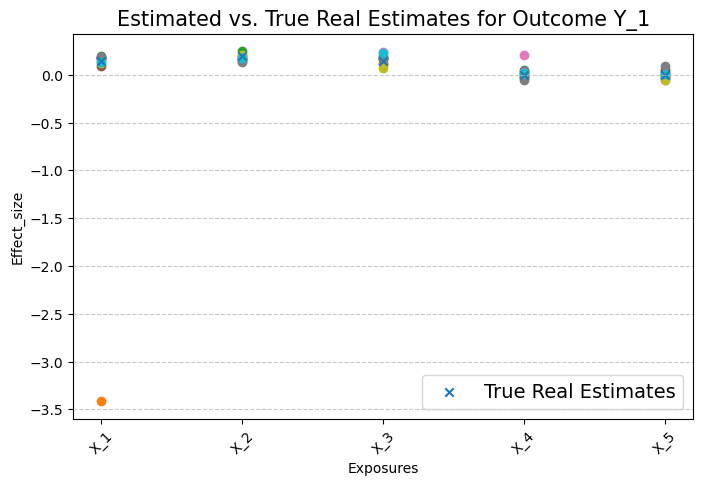

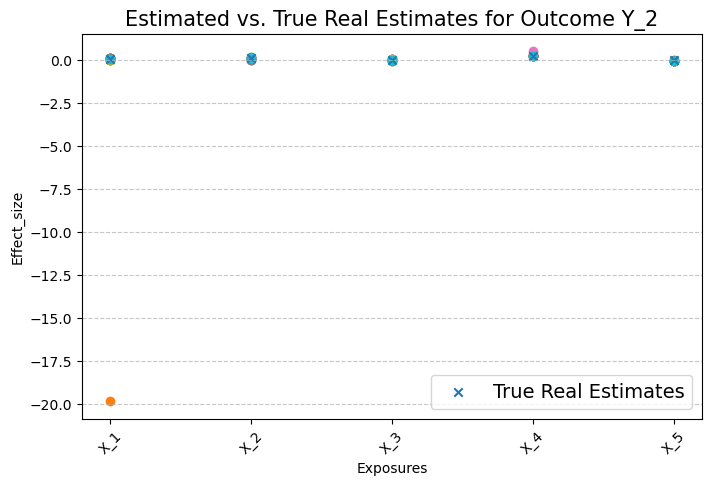

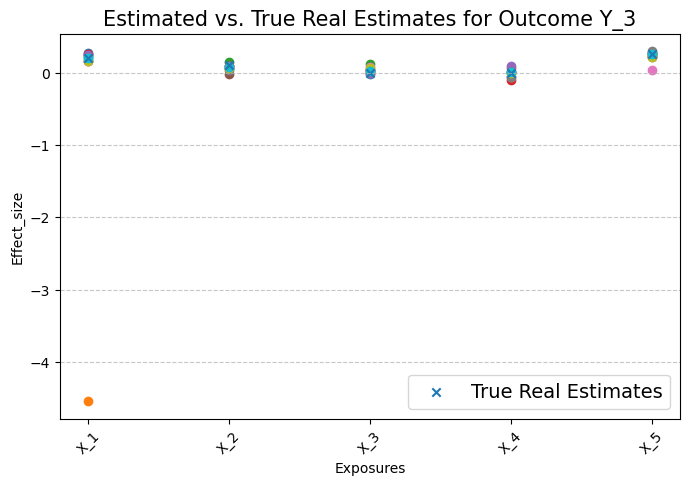

In [230]:
import matplotlib.pyplot as plt

# Number of exposures
num_exposures = len(estimated_effects_matrix.index)

# Define the exposure labels (X_1 to X_100)
exposure_labels = [f'X_{i}' for i in range(1, num_exposures + 1)]

# Define columns names of correlated_effect matrix
correlated_effect = pd.DataFrame(correlated_effect).rename(columns = {0:'Y_1', 1: 'Y_2', 2: 'Y_3'})
# Plot for each outcome
for outcome_column in estimated_effects_matrix.columns:
    # Extract estimated effects and true real estimates for the outcome
    estimated_effects = estimated_effects_matrix[outcome_column]
    true_real_estimates = correlated_effect[outcome_column]
    
    # Create a scatter plot with a larger x-axis
    plt.figure(figsize=(8, 5))  # Adjust the figsize as needed
    # pdb.set_trace()
    for j in range(chunk_size):
        serie = []
        for i in range(5):
            serie.append(estimated_effects.iloc[i][j])
            #serie.append(estimated_effects_matrix.iloc[i,0][j])
        plt.scatter(range(1, num_exposures + 1), serie) #  label='Estimated Effects'
    plt.scatter(range(1, num_exposures + 1), true_real_estimates, label='True Real Estimates', marker='x')
    
    # Add labels and title
    plt.xlabel('Exposures')
    plt.ylabel('Effect_size')
    plt.title(f'Estimated vs. True Real Estimates for Outcome {outcome_column}', fontsize = 15)
    
    # Set x-axis labels
    plt.xticks(range(1, num_exposures + 1), exposure_labels, rotation=45)
    #plt.ylim(-0.5,0.5)
    
    # Add gridlines
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Add legend
    plt.legend(fontsize=14)
    
    # Show the plot
    plt.show()

In [200]:
matrix = np.random.uniform(low=0.1, high=0.5, size=(correlated_effect.shape[1], correlated_effect.shape[1]))
noise=np.random.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])

/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_2724/2913953789.py:2: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=np.random.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])


In [201]:
noise

array([[ 0.2535041 ,  0.75489199,  0.64057539],
       [ 1.4850583 ,  1.44830046,  1.00171868],
       [-0.85036089, -0.39643916, -0.61618901],
       [-0.7999473 , -2.07503094, -1.10362575],
       [ 0.0604569 , -0.98452864, -0.49797914],
       [-0.5877158 ,  0.02968386, -0.66646371]])

# MR multi-exposures 1 outcome

In [8]:
exposures = dataset_S1.iloc[:, 3:]  # Assuming exposures are in columns X_1 to X_5
outcomes = dataset_S1.iloc[:, :3]   # Assuming outcomes are in columns Y_1, Y_2, Y_3

# Initialize a matrix to store estimated effects
num_exposures = exposures.shape[1]
num_outcomes = outcomes.shape[1]
estimated_effects_matrix = pd.DataFrame(index=exposures.columns, columns=outcomes.columns)

# Fit OLS model for each outcome using all exposures
for outcome_column in outcomes.columns:
    X = sm.add_constant(exposures)  # Add a constant term for the intercept
    y = outcomes[outcome_column]
    model = sm.OLS(y, X).fit()

    # Store the estimated effects for the current outcome, excluding the constant
    estimated_effects_matrix[outcome_column] = model.params[1:]

# Display the estimated effects matrix
print(estimated_effects_matrix)


          Y_1       Y_2       Y_3
X_1  0.092358  0.078946  0.102354
X_2  0.113488  0.100572  0.051661
X_3  0.197806  0.038683  0.107061
X_4  0.093368  0.282254  0.060639
X_5  0.015383  0.002345  0.286090


## Plot true effects vs estimated effects¶

/Users/mario/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/mario/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_5084/3705737185.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


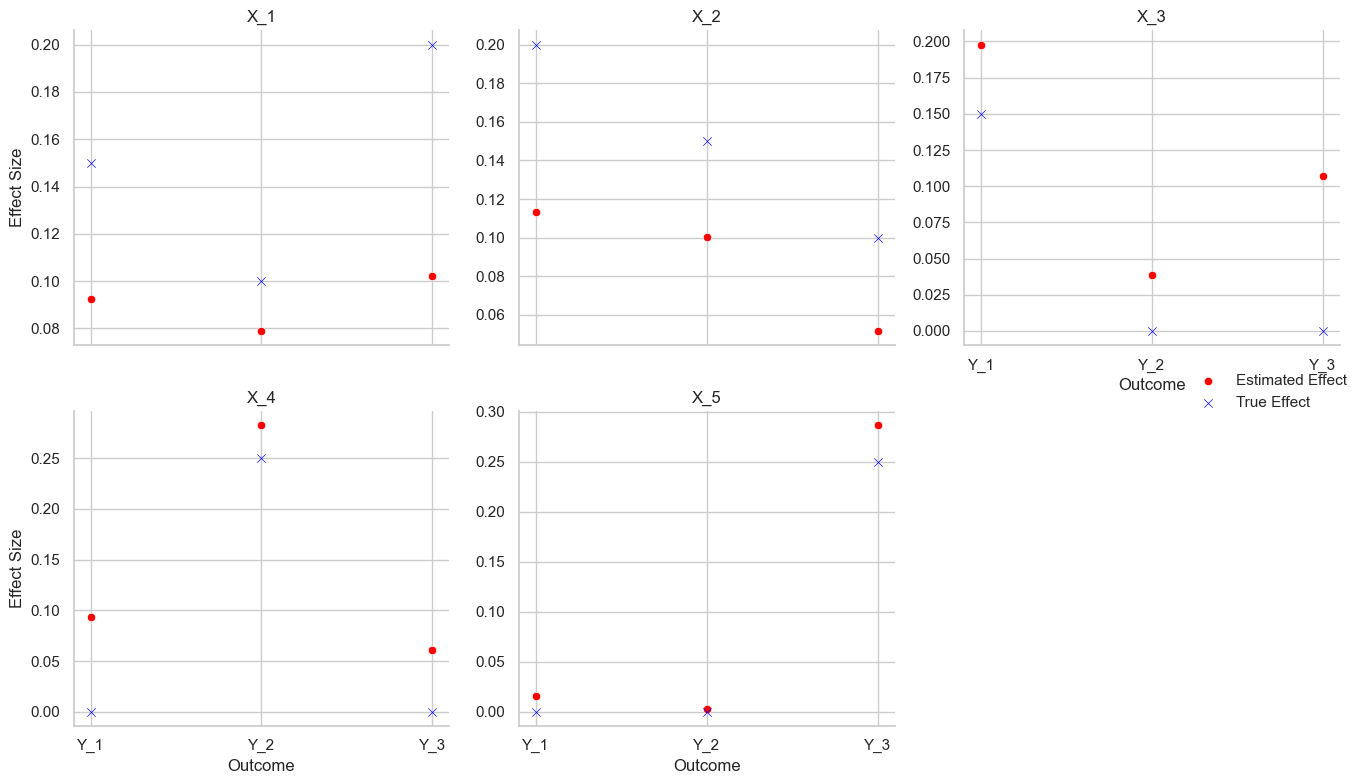

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust correlated effect indices
correlated_effect.index = ["X_1", "X_2", "X_3", "X_4", "X_5"]

# Convert estimated_effects_matrix to a long format for plotting
estimated_effects_long = estimated_effects_matrix.reset_index().melt(id_vars='index', var_name='Outcome', value_name='Estimated Effect')
estimated_effects_long.rename(columns={'index': 'Exposure'}, inplace=True)

# Convert correlated_effects to a long format
correlated_effects_long = correlated_effect.reset_index().melt(id_vars='index', var_name='Outcome', value_name='True Effect')
correlated_effects_long.rename(columns={'index': 'Exposure'}, inplace=True)

# Merge the two DataFrames on Exposure and Outcome columns
merged_effects = pd.merge(estimated_effects_long, correlated_effects_long, on=['Exposure', 'Outcome'])

# Convert Exposure column to categorical for proper ordering in the plot
merged_effects['Exposure'] = pd.Categorical(merged_effects['Exposure'], categories=exposure_labels, ordered=True)

# Set seaborn style
sns.set(style="whitegrid")

# Plotting
g = sns.FacetGrid(merged_effects, col='Exposure', col_wrap=3, height=4, sharey=False)
g.map_dataframe(sns.scatterplot, x='Outcome', y='Estimated Effect', marker='o', color='red', label='Estimated Effect')
g.map_dataframe(sns.scatterplot, x='Outcome', y='True Effect', marker='x', color='blue', label='True Effect')
g.add_legend()

# Set axis labels and titles
g.set_axis_labels("Outcome", "Effect Size")
g.set_titles(col_template="{col_name}")

# Adjust layout
plt.tight_layout()
plt.show()


In [10]:
merged_effects

,Exposure,Outcome,Estimated Effect,True Effect
0,X_1,Y_1,0.092358,0.15
1,X_2,Y_1,0.113488,0.20
2,X_3,Y_1,0.197806,0.15
3,X_4,Y_1,0.093368,0.00
4,X_5,Y_1,0.015383,0.00
5,X_1,Y_2,0.078946,0.10
6,X_2,Y_2,0.100572,0.15
7,X_3,Y_2,0.038683,0.00
8,X_4,Y_2,0.282254,0.25
9,X_5,Y_2,0.002345,0.00


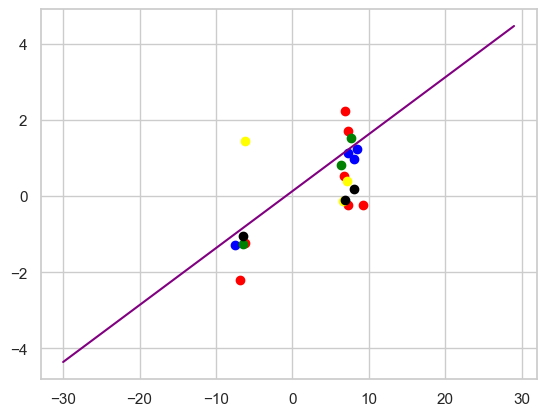

In [11]:
import matplotlib.pyplot as plt
x = np.array([i for i in range(-30,30,1)])
#     X = sm.add_constant(exposures.loc[dico[exposure_column],exposure_column])
#     y = outcomes.loc[dico[exposure_column],outcome_column]
plt.scatter(exposures.loc[dico["X_1"],"X_1"],outcomes.loc[dico["X_1"],"Y_1"],label="1",color="blue")
plt.scatter(exposures.loc[dico["X_2"],"X_2"],outcomes.loc[dico["X_2"],"Y_1"],label="2",color="red")
plt.scatter(exposures.loc[dico["X_3"],"X_3"],outcomes.loc[dico["X_3"],"Y_1"],label="3",color="green")
plt.scatter(exposures.loc[dico["X_4"],"X_4"],outcomes.loc[dico["X_4"],"Y_1"],label="4",color="yellow")
plt.scatter(exposures.loc[dico["X_5"],"X_5"],outcomes.loc[dico["X_5"],"Y_1"],label="5",color="black")
plt.plot(x, 0.149415 * x + 0.126813, color='purple', label='Régression linéaire')
# median_value = exposures['X_1'].median()
# x = exposures[exposures['X_1'] < median_value]['X_1'].values
# y = outcomes[exposures['X_1'] < median_value]['Y_1'].values

In [12]:
import statsmodels.api as sm
sm.OLS(outcomes["Y_1"], sm.add_constant(exposures)).fit().params

const   -0.216034
X_1      0.092358
X_2      0.113488
X_3      0.197806
X_4      0.093368
X_5      0.015383
dtype: float64

In [13]:
# méthode classique
np.polyfit(exposures["X_1"], outcomes["Y_1"], 1)

array([ 0.12482783, -0.06078743])

In [14]:
# IVW
scenar = 3
IVs = results_df['IV Indices'].iloc[scenar]
exposures = results_df.loc[scenar,"Base Dataset"].iloc[IVs, 3:]
outcomes = results_df.loc[scenar,"Base Dataset"].iloc[IVs, :3]
for outcome_column in outcomes.columns:
    stdY = results_df.loc[scenar,"Standard Deviation"][outcome_column]
    for exposure_column in exposures.columns:
        B = outcomes[outcome_column]/exposures[exposure_column]
        N = sum((exposures[exposure_column]**2)*(stdY**-2)*B)
        D = sum((exposures[exposure_column]**2)*(stdY**-2))
        print(N/D)

0.1372805228718571
0.14852098020452453
0.15489033891520293
-0.008243035589995467
0.010860366185837403
0.09410920845216333
0.09750983948853152
0.014978896217214925
0.2352094867333532
0.03380940487214923
0.15548984005214125
0.09832565473319739
0.0038887049978205265
0.006751409998144389
0.25350819663831925


In [15]:
# IVW
scenar = 3
IVs = results_df['IV Indices'].iloc[scenar]
exposures = results_df.loc[scenar,"Base Dataset"].iloc[:, 3:]
outcomes = results_df.loc[scenar,"Base Dataset"].iloc[:, :3]
for outcome_column in outcomes.columns:
    stdY = results_df.loc[scenar,"Standard Deviation"][outcome_column]
    for exposure_column in exposures.columns:
        B = outcomes[outcome_column]/exposures[exposure_column]
        Z = np.polyfit(exposures[exposure_column], outcomes[outcome_column], 1)
        N = sum((exposures[exposure_column]**2)*(stdY**-2)*B)
        D = sum((exposures[exposure_column]**2)*(stdY**-2))
        print(N/D)

0.0943017526201804
0.09581494642544602
0.0885487831237427
0.003973472281121384
0.007670384701930444
0.061316691585727875
0.060766784780393324
0.011057423300573953
0.12712394581154224
0.018896759399347363
0.10209257140535524
0.06522585581543937
0.007304892715953893
0.002989193523388582
0.12166138935398921


In [16]:
# Median-based
for outcome_column in outcomes.columns:
    for exposure_column in exposures.columns:
        B = outcomes[outcome_column]/exposures[exposure_column]
        print(B.median())

0.039159883085407174
0.014415576009766907
0.01900364800898143
0.033459074285340104
0.006113388493973228
0.00856686597323822
0.005873865554982338
-0.001766247561334571
0.022894137182804027
0.023817729870272586
0.010168014815370418
0.02281303217826608
-0.011137409106252803
0.009527999124380715
0.00633342007573564


In [61]:
# Weighted Median Estimator
# for outcome_column in outcomes.columns:
#     stdY = results_df.loc[scenar,"Standard Deviation"][outcome_column]
#     for exposure_column in exposures.columns:
#         B = outcomes[outcome_column]/exposures[exposure_column]
#         W = exposures[exposure_column]**2/stdY**2
#         R = W/sum(W)
#         R = np.cumsum(R)
#         indice = np.where(R.values>0.5)[0][0]
#         BWM = B.iloc[indice-1]+(B.iloc[indice]-B.iloc[indice-1])*((0.5-R.iloc[indice-1])/(R.iloc[indice]-R.iloc[indice-1]))
#         print(R.iloc[indice-1],B.iloc[indice-1],BWM)